In [36]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

config

In [28]:
CSV_PATH = "../processing/master_with_paths.csv"

ALLOWED_LIGHT_FOLDERS = {"Point Light", "Spot Light", "Area Light"}
MATERIAL = "PlasticGlossy"
BATCH = "Batch 3 - Cycles Filmic"
NUM_ACTIVE_LIGHTS = 1

data preprocessing

In [29]:
# put csv data into dataframes
df = pd.read_csv(CSV_PATH, low_memory=False)
filtered = df[
    df["light_folder"].isin(ALLOWED_LIGHT_FOLDERS)
    & (df["num_active_lights"].astype(int) == NUM_ACTIVE_LIGHTS)
    & (df["material_folder"].astype(str) == MATERIAL)
    & (df["batch_folder"].astype(str) == BATCH)
].copy()

# relevant columns + per-light data + camera data
base_cols = [
    "image_relpath",
    "shape_name",
    "material_folder",
    "light_folder",
    "batch_folder",
    "frame",
    "config_id",
    "camera_png",
    "camera_name",
    "cam_pos_x", "cam_pos_y", "cam_pos_z",
    "cam_forward_x", "cam_forward_y", "cam_forward_z",
    "cam_up_x", "cam_up_y", "cam_up_z",
    "cam_right_x", "cam_right_y", "cam_right_z",
    "focal_length_mm",
    "hdri_path",
    "ambient_strength",
    "hdri_rot_z_rad",
]

# per-light columns
light_cols = [c for c in filtered.columns if c.startswith("light0_")]
keep_cols = [c for c in base_cols if c in filtered.columns] + light_cols
filtered = filtered[keep_cols].copy()

# clean up
numeric_prefixes = (
    "cam_", "light0_", "ambient_strength", "hdri_rot_z_rad", "focal_length_mm", "frame", "config_id", "camera_png"
)
for col in filtered.columns:
    if col.startswith(("cam_", "light0_")) or col in {"ambient_strength", "hdri_rot_z_rad", "focal_length_mm", "frame", "config_id", "camera_png"}:
        filtered[col] = pd.to_numeric(filtered[col], errors="coerce")

# split into df by lighting setup
dfs_by_setup = {
    setup: grp.reset_index(drop=True)
    for setup, grp in filtered.groupby("light_folder", sort=True)
}

In [ ]:
def load_and_resize_image(image_path, size=(224, 224)):
    """Load an image and resize it to the specified size."""
    try:
        img = Image.open(image_path)
        img = img.resize(size, Image.Resampling.LANCZOS)
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def process_images_for_df(df, dataset_root="../data"):
    """Process images in the dataframe to 224x224 and add them as an array column."""
    images = []
    valid_indices = []
    
    for idx, row in df.iterrows():
        img_path = os.path.join(dataset_root, row["image_relpath"])
        img_array = load_and_resize_image(img_path)
        
        if img_array is not None:
            images.append(img_array)
            valid_indices.append(idx)
        else:
            print(f"Skipping row {idx}: {img_path}")
    
    # filter to only include valid images
    df_processed = df.iloc[valid_indices].reset_index(drop=True)
    df_processed["image"] = images
    
    return df_processed

# process images for each lighting setup
images_by_setup = { setup: process_images_for_df(grp) for setup, grp in dfs_by_setup.items()}

In [ ]:
# lighting features to predict
lighting_features = [
    "light0_energy",
    "light0_color_r", "light0_color_g", "light0_color_b",
    "light0_pos_x", "light0_pos_y", "light0_pos_z",
    "light0_dir_x", "light0_dir_y", "light0_dir_z",
]

# all processed dataframes
combined_df = pd.concat([df for df in images_by_setup.values()], ignore_index=True)

# extract images & lighting targets
X_images = np.array([img.astype(np.float32) / 255.0 for img in combined_df["image"]])
y_targets = combined_df[lighting_features].fillna(0).values.astype(np.float32)

# normalize target features
scaler = StandardScaler()
y_targets_scaled = scaler.fit_transform(y_targets)

# cnn model to predict lighting features from images
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(lighting_features), activation='linear') # output layer
])

# compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print(model.summary())
print(f"\nTraining data shape: {X_images.shape}")
print(f"Target data shape: {y_targets_scaled.shape}")

2026-02-01 18:42:50.072842: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-01 18:42:50.124319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-01 18:42:51.285813: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/kaclark219/anaconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1769992995.424821  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,529,994 (169.87 MB)

 Trainable params: 44,529,994 (169.87 MB)

 Non-trainable params: 0 (0.00 B)

None

Training data shape: (7956, 224, 224, 3)
Target data shape: (7956, 10)


Training samples: 6364
Test samples: 1592


2026-02-01 18:44:39.247344: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 3065352192 exceeds 10% of free system memory.


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - loss: 0.5292 - mae: 0.5264

2026-02-01 18:47:13.508269: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 766488576 exceeds 10% of free system memory.


160/160 ━━━━━━━━━━━━━━━━━━━━ 158s 981ms/step - loss: 0.3886 - mae: 0.4305 - val_loss: 0.0318 - val_mae: 0.1092
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 953ms/step - loss: 0.0415 - mae: 0.1414 - val_loss: 0.0034 - val_mae: 0.0379
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 953ms/step - loss: 0.0264 - mae: 0.1091 - val_loss: 0.0079 - val_mae: 0.0602
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 950ms/step - loss: 0.0192 - mae: 0.0901 - val_loss: 0.0043 - val_mae: 0.0445
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 948ms/step - loss: 0.0156 - mae: 0.0804 - val_loss: 0.0012 - val_mae: 0.0187
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 150s 940ms/step - loss: 0.0116 - mae: 0.0681 - val_loss: 0.0022 - val_mae: 0.0276
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 155s 969ms/step - loss: 0.0098 - mae: 0.0626 - val_loss: 5.8103e-04 - val_mae: 0.0161
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 953ms/step - loss: 0.0097 - mae: 0.0615 - val_loss: 2.4247e-04 - val_mae: 0.0097
Epoch 9/20
160/160 ━━━━━━━━

2026-02-01 19:35:33.496657: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 958562304 exceeds 10% of free system memory.



Test Loss: 0.0000
Test MAE: 0.0038


2026-02-01 19:35:41.922555: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 958562304 exceeds 10% of free system memory.


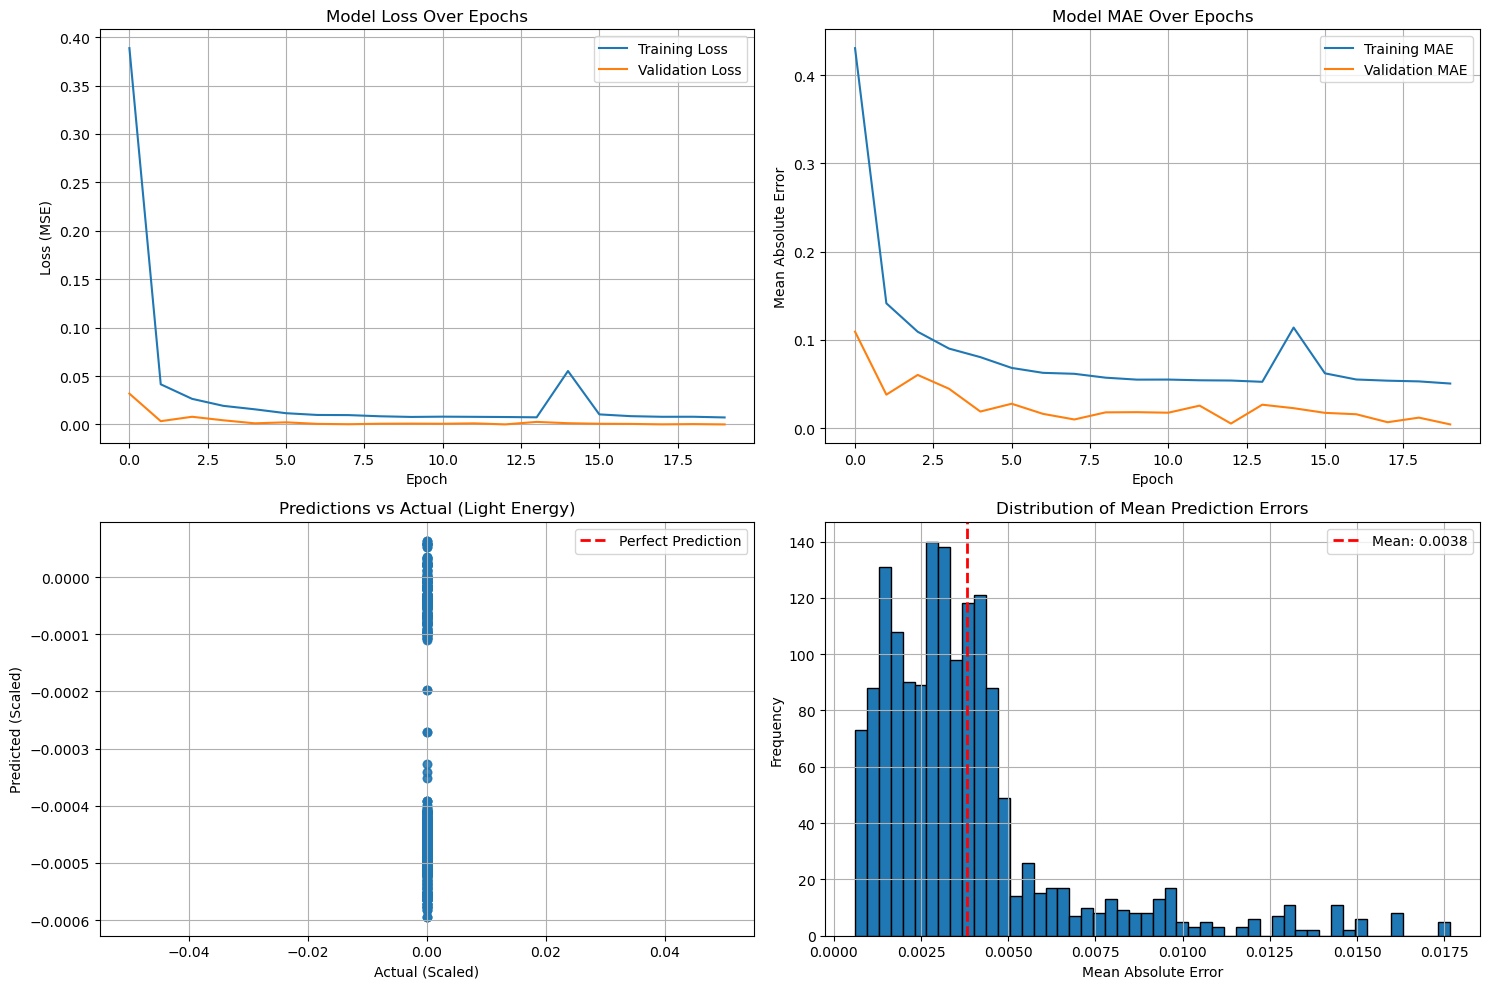


Per-feature MAE on test set:
light0_energy: 0.0003
light0_color_r: 0.0010
light0_color_g: 0.0003
light0_color_b: 0.0004
light0_pos_x: 0.0063
light0_pos_y: 0.0059
light0_pos_z: 0.0057
light0_dir_x: 0.0058
light0_dir_y: 0.0064
light0_dir_z: 0.0061


In [ ]:
# split the data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_images, y_targets_scaled, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

# evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# training & validation loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss Over Epochs')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# training & validation mae
axes[0, 1].plot(history.history['mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].set_title('Model MAE Over Epochs')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Mean Absolute Error')
axes[0, 1].legend()
axes[0, 1].grid(True)

# predictions vs actual for light energy
y_pred = model.predict(X_test, verbose=0)
axes[1, 0].scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
axes[1, 0].plot([y_test[:, 0].min(), y_test[:, 0].max()], 
                [y_test[:, 0].min(), y_test[:, 0].max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_title('Predictions vs Actual (Light Energy)')
axes[1, 0].set_xlabel('Actual (Scaled)')
axes[1, 0].set_ylabel('Predicted (Scaled)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# prediction error distribution
errors = np.abs(y_test - y_pred)
mean_errors = errors.mean(axis=1)
axes[1, 1].hist(mean_errors, bins=50, edgecolor='black')
axes[1, 1].set_title('Distribution of Mean Prediction Errors')
axes[1, 1].set_xlabel('Mean Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(mean_errors.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_errors.mean():.4f}')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# per feature mae to find struggling features
print("\nPer-feature MAE on test set:")
feature_errors = np.abs(y_test - y_pred).mean(axis=0)
for i, feature in enumerate(lighting_features):
    print(f"{feature}: {feature_errors[i]:.4f}")